In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 画图的主题设计
sns.set_theme()
sns.set_context('notebook')

# 数据获取
数据中有5个维度的字段，其分别表示用户id、商品id、用户行为类型、商品类别以及时间信息。充分理解这些字段的含义是数据分析的基础，这里我们列出这些字段的主要信息：

| 字段          | 字段说明                     | 提取说明                             |
|---------------|-----------------------------|-------------------------------------|
| `user_id`     | 用户标识                     | 抽样和字段脱敏                       |
| `item_id`     | 商品标识                     | 字段脱敏                             |
| `behavior_type` | 用户对商品的行为类型         | 包括浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4 |
| `item_category` | 商品分类标识                 | 字段脱敏                             |
| `time`        | 行为时间                     | 精确到小时级别                       |

In [2]:
data_user = pd.read_csv("../dataset/alibaba_eshop_user_action.zip")
data_user.head(20)

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21
5,93784494,337869048,1,3979,2014-12-03 20
6,94832743,105749725,1,9559,2014-12-13 20
7,95290487,76866650,1,10875,2014-11-27 16
8,96610296,161166643,1,3064,2014-12-11 23
9,100684618,21751142,3,2158,2014-12-05 23


In [3]:
# 查看数据集量级
print('整体数据的大小为: ', len(data_user))

print('数据集中用户数量是: ', len(set(data_user['user_id'])))
print('数据集中商品数量是: ', len(set(data_user['item_id'])))
print('数据集中商品类别数量是: ', len(set(data_user['item_category'])))

整体数据的大小为:  12256906
数据集中用户数量是:  10000
数据集中商品数量是:  2876947
数据集中商品类别数量是:  8916


In [4]:
# 查看数据缺失情况
data_user.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
dtype: int64

In [5]:
# 分割天(date)和小时(hour)
data_user['date'] = data_user['time'].map(lambda x: x.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda x: x.split(' ')[1])
data_user.head()

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [6]:
# 查看字段类型：
data_user.dtypes

user_id           int64
item_id           int64
behavior_type     int64
item_category     int64
time             object
date             object
hour             object
dtype: object

In [7]:
# 数据类型转换
data_user['user_id'] = data_user['user_id'].astype('object')
data_user['item_id'] = data_user['item_id'].astype('object')
data_user['item_category'] = data_user['item_category'].astype('object')
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['hour'] = data_user['hour'].astype('int64')

In [8]:
data_user.dtypes

user_id                  object
item_id                  object
behavior_type             int64
item_category            object
time                     object
date             datetime64[ns]
hour                      int64
dtype: object

# EDA
## Part1: 流量分析

### 1. 基于天级别访问流量分析
我们先从宏观的流量分析入手，来看看能发现哪有有趣的规律。我们主要关注访问量(PV)与独立访问量(UV)：
+ 访问量(PV)：基于用户每次对淘宝页面的刷新次数，用户每刷新一次页面或者打开新的页面就记录就算一次访问。
+ 独立访问量(UV)：一个用户若多次访问淘宝只记录一次

In [9]:
# 计算PV: PageView , UV: UniqueView
# PV: select count(user_id) from data_user group by "date";
# UV: select count(distinct(user_id)) from data_user group by "date";

pv_daily = data_user.groupby('date')['user_id'].count()
pv_daily = pv_daily.reset_index() 
pv_daily = pv_daily.rename(columns={'user_id':'pv_daily'})
pv_daily

,date,pv_daily
0,2014-11-18,366701
1,2014-11-19,358823
2,2014-11-20,353429
3,2014-11-21,333104
4,2014-11-22,361355
5,2014-11-23,382702
6,2014-11-24,378342
7,2014-11-25,370239
8,2014-11-26,360896
9,2014-11-27,371384


In [10]:
# 计算UV
uv_daily = data_user.groupby('date')['user_id'].apply(lambda x: len(x.unique()))
uv_daily = uv_daily.reset_index()
uv_daily = uv_daily.rename(columns = {'user_id':'uv_daily'})
uv_daily

,date,uv_daily
0,2014-11-18,6343
1,2014-11-19,6420
2,2014-11-20,6333
3,2014-11-21,6276
4,2014-11-22,6187
5,2014-11-23,6373
6,2014-11-24,6513
7,2014-11-25,6351
8,2014-11-26,6357
9,2014-11-27,6359


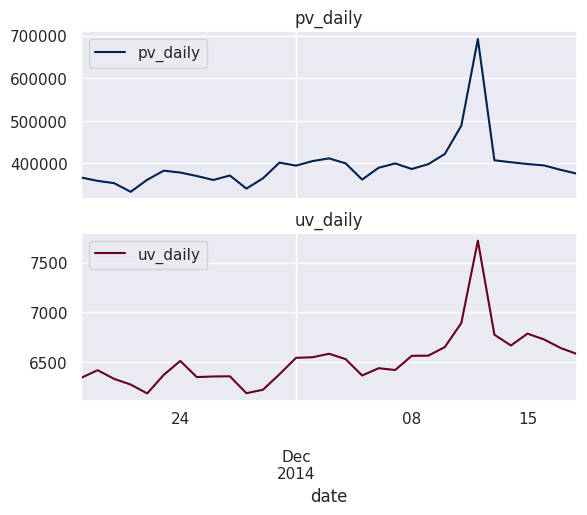

In [11]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
# pv_daily: pandas 对象
# Matplotlib, Pandas , histplot:  柱状图
pv_daily.plot(x='date', y='pv_daily', ax=axes[0], colormap='cividis')
uv_daily.plot(x='date', y='uv_daily', ax=axes[1], colormap='RdGy')
axes[0].set_title('pv_daily')
axes[1].set_title('uv_daily')
plt.show()

可以看出，不管是PV还是UV趋势，均在12号的时候出现了一个尖峰，这正是著名的双十二大促节的用户集中消费导致的变化。 通过简单的数据分析和可视化工具，这是我们从数据中观察到了第一个结论。

### 2. 基于小时级别访问流量分析
上面的对不同访问量进行分析，其分析的时间跨度是每天。另外从我们的直觉可以知道，用户在一天当中对淘宝的使用也是有一定规律的。为了探索这个规律，我们将按照每小时统计用户的访问量和独立访问量。同pv_daily, uv_daily分析，我们完成如下代码：

In [12]:
# 计算每小时的PV
pv_hour = data_user.groupby('hour')['user_id'].count()
pv_hour = pv_hour.reset_index()
pv_hour = pv_hour.rename(columns={'user_id':'pv_hour'})
pv_hour

,hour,pv_hour
0,0,517404
1,1,267682
2,2,147090
3,3,98516
4,4,80487
5,5,88296
6,6,158798
7,7,287337
8,8,396106
9,9,485951


In [13]:
# 计算每小时UV
uv_hour = data_user.groupby('hour')['user_id'].apply(lambda x: len(x.unique()))
uv_hour = uv_hour.reset_index()
uv_hour = uv_hour.rename(columns={'user_id':'uv_hour'})
uv_hour

,hour,uv_hour
0,0,5786
1,1,3780
2,2,2532
3,3,1937
4,4,1765
5,5,2030
6,6,3564
7,7,5722
8,8,7108
9,9,7734


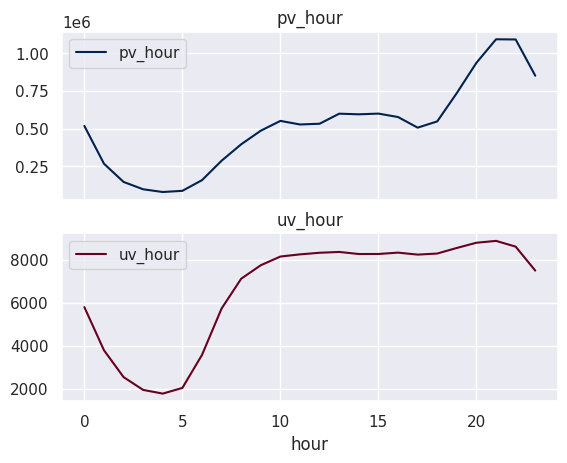

In [14]:
# 可视化
fig, axes = plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
uv_hour.plot(x='hour', y='uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('uv_hour')
plt.show()

可以看出，PV的高峰值出现在20点之后，可能的原因是淘宝的主力消费人群是工薪阶层，这部分群体在下班后开始使用淘宝浏览购物；UV的值比较恒定，上午10点之后便没有出现大的波动，一个可能的原因是用户早晨也会刷一下淘宝，比如看看物流状态，UV值在一天之内就不会再有大的变化波动了。 另外也可以看出，凌晨2点之后，PV/UV的趋势一致，均是一天中流量最小的时间段。

从“日PV/UV”趋势看，双十二当天的总体流量会出现明显的峰值。那么双十二当天基于小时的用户访问数据会有变化吗？我们来写代码分析：

In [15]:
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']

# 计算每小时的PV
pv_hour_1212 = data_user_1212.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'1212_pv_hour'})
uv_hour_1212 = data_user_1212.groupby('hour')['user_id'].apply(lambda x: len(x.unique())).reset_index().rename(columns={'user_id':'1212_uv_hour'})
pv_hour_1212

,hour,1212_pv_hour
0,0,50030
1,1,22761
2,2,11754
3,3,6173
4,4,5168
5,5,6417
6,6,12820
7,7,22177
8,8,28156
9,9,32695


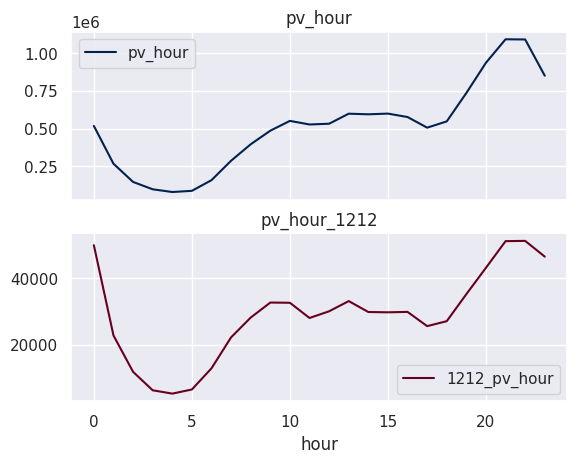

In [16]:
# 为了方便对比，我们和30日总体的小时级别PV/UV变化趋势做对比
fig, axes = plt.subplots(2,1,sharex=True)

# 对比PV
pv_hour.plot(x='hour',y='pv_hour',ax=axes[0],colormap='cividis')
pv_hour_1212.plot(x='hour', y='1212_pv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('pv_hour')
axes[1].set_title('pv_hour_1212')
plt.show()

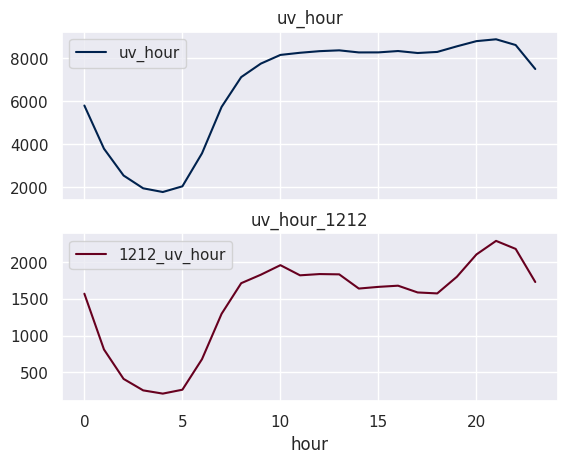

In [17]:
# 对比UV
fig, axes = plt.subplots(2,1,sharex=True)
uv_hour.plot(x='hour',y='uv_hour',ax=axes[0],colormap='cividis')
uv_hour_1212.plot(x='hour', y='1212_uv_hour', ax=axes[1],colormap='RdGy')
axes[0].set_title('uv_hour')
axes[1].set_title('uv_hour_1212')
plt.show()

可以看到，双十二当天，PV变化趋与一个月内的PV变化趋势基本一致，只不过曲线不太平滑，多出来小的凸点，一个可能的原因是大促当天，有整点领券活动，通过推送等形式会有效拉动用户使用淘宝。UV变化趋势稍有不同，可以看到双十二当天在晚上8点之后UV出现了小高峰，表明了大促当天用户的消费意愿还是比较强烈。

我们再来看看4类用户行为的流量趋势：

### 3. 不同用户行为流量分析
众所周知，淘宝用户分布广泛，不同的用户的购物行为有较大差异。比如不同的用户的登录习惯以及购买偏好，因此按照用户的角度进行分析是重要且有趣的。因此我们依旧从用户访问量的这一数据来分析不同用户的浏览淘宝的习惯。

为了获得用户的行为模式，我们主要统计在一天当中（按照每小时）用户发生的行为。因此我们使用groupby进行数据分组，方式如下：

In [18]:
# 基于 behavior_type & hour 分组
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
pv_behavior = data_user.groupby(['behavior_type','hour'])['user_id'].count()
pv_behavior = pv_behavior.reset_index()
pv_behavior = pv_behavior.rename(columns={'user_id':'pv_behavior'})
pv_behavior

,behavior_type,hour,pv_behavior
0,1,0,487341
1,1,1,252991
2,1,2,139139
3,1,3,93250
4,1,4,75832
...,...,...,...
91,4,19,6352
92,4,20,7872
93,4,21,8829
94,4,22,8845


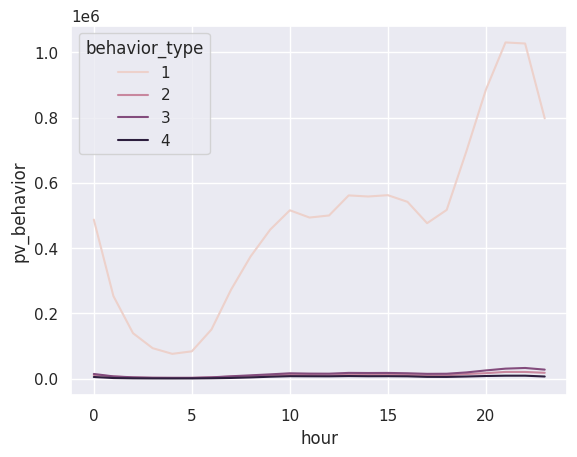

In [19]:
# 可视化
ax = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior)

因为action_type为1（浏览行为）的占比非常大，导致上图其它几类action的趋势不太明显，我们去掉action_type为1的数据后再来看看：

<AxesSubplot:xlabel='hour', ylabel='pv_behavior'>

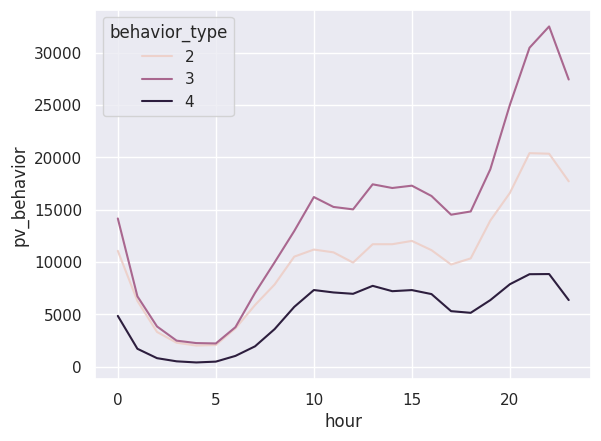

In [20]:
sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_behavior[pv_behavior.behavior_type!=1])

可以看出4种行为按照小时的变化趋势基本一致，都是在晚上8点之后有明显增长，凌晨2-6点是低峰，符合常识。感兴趣的小伙伴可以进一步基于双十二当天的数据来分析下4种行为的变化趋，看看有什么新的发现？

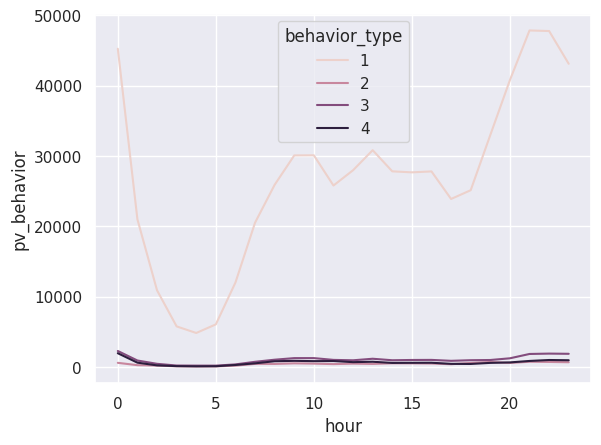

In [21]:
# 基于 behavior_type & hour 分组
# 点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示
ds_1212 = data_user.loc[data_user['date']=='2014-12-12']
pv_1212 = ds_1212.groupby(['behavior_type','hour'])['user_id'].count()
pv_1212 = pv_1212.reset_index()
pv_1212 = pv_1212.rename(columns={'user_id':'pv_behavior'})

# 可视化
ax = sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_1212)

<AxesSubplot:xlabel='hour', ylabel='pv_behavior'>

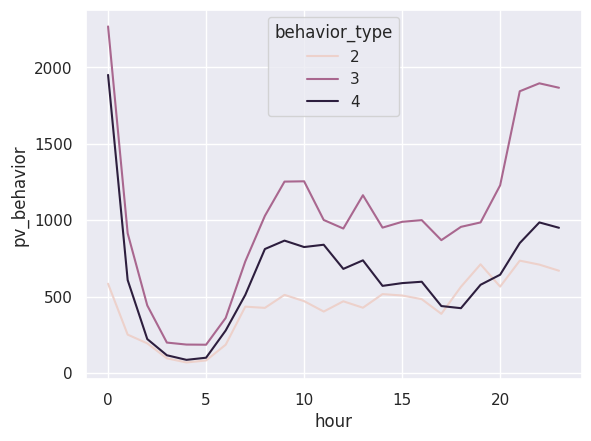

In [22]:
sns.lineplot(x='hour',y='pv_behavior',hue='behavior_type',data=pv_1212[pv_1212.behavior_type!=1])

我们在充分了解用户分时的数据趋势后，可以针对性的进行营销活动，如推送优惠劵等，大家也可以留意下日常使用电商类App的推送通知的推送时间，一般都是在用户高峰期来做推送，可进一步促进转化率。

## Part2: 转化率分析
我们来分析“浏览-收藏/加购-购买”链路的转化漏斗模型，可以帮助我们更好的了解各个环节的转化链路：

In [23]:
behavior_type = data_user.groupby(['behavior_type'])['user_id'].count()
behavior_type

behavior_type
1    11550581
2      242556
3      343564
4      120205
Name: user_id, dtype: int64

In [24]:
# 用户浏览（action_type=1）的基数是最大的，因为加购和收藏没有必然联系，因此我们把这两类合并在一起做分析
click_num, fav_num, add_num, pay_num =  behavior_type[1], behavior_type[2], behavior_type[3], behavior_type[4]
fav_add_num = fav_num + add_num 

print('加购/收藏转化率：', 100 * fav_add_num / click_num)
print('点击 到 购买转化率: ', 100 * pay_num / click_num)
print('加购/收藏 到 购买转化率: ', 100 * pay_num / fav_add_num)

加购/收藏转化率： 5.074376778103197
点击 到 购买转化率:  1.0406835811982098
加购/收藏 到 购买转化率:  20.508598921722513


可以观察到，从浏览到加购/收藏的转化率大约5%；“加购/收藏”后到购买转化率大约为20%，这个比例还是还是非常高的，说明用户感兴趣的商品更容易成单。 两者相乘，我们能粗略估出从浏览到购买的转化率约为1%左右。

我们再来看看双十二当天的数据，看看是否有不同的结论？

In [31]:
data_user_1212 = data_user.loc[data_user['date']=='2014-12-12']
behavior_type = data_user_1212.groupby(['behavior_type'])['user_id'].count()

click_num, fav_num, add_num, pay_num =  behavior_type[1], behavior_type[2], behavior_type[3], behavior_type[4]

fav_add_num = fav_num + add_num 
print('双十二 加购/收藏转化率：', 100 * fav_add_num / click_num)
print('双十二 点击 到 购买转化率: ', 100 * pay_num / click_num)
print('双十二 加购/收藏 到 购买转化率: ', 100 * pay_num / fav_add_num)

双十二 加购/收藏转化率： 5.448732437837779
双十二 点击 到 购买转化率:  2.3773707847303305
双十二 加购/收藏 到 购买转化率:  43.631630142472964


可以看出，双十二当天，加购/收藏 到 购买转化率是平时的2倍之多，此外，加购/收藏 的转化率也比平时高出不少，说明大促的运营活动对用户活跃度的转化起到了很好的促进作用。
作为商家来讲，可以考虑在特定节日推出特定主题的优惠活动，是个有效的促活、转化的方式。

## Part3. 用户价值分析
在分析完整体变化趋势和转化率之后，商家更关注的是用户行为，什么用户是有价值的，什么用户是潜在用户？商业上已经有不少成熟的模型可供参考，如用户价值RFM分析模型等，在此不做详细解释。本项目中我们还是从实际问题出发，站在用户购买行为的角度来探索用户价值：

### 1. 用户购买频次分析
从上面的统计结果来看，用户的点击数据是最多的，但是从淘宝盈利的角度来说，只有购买行为是商家最为关注的，这里就会引入一个问题：在给定的数据集上，淘宝用户购买东西的频次有多少？基于这个问题，我们可以用统计的方法计算。计算结果如下：

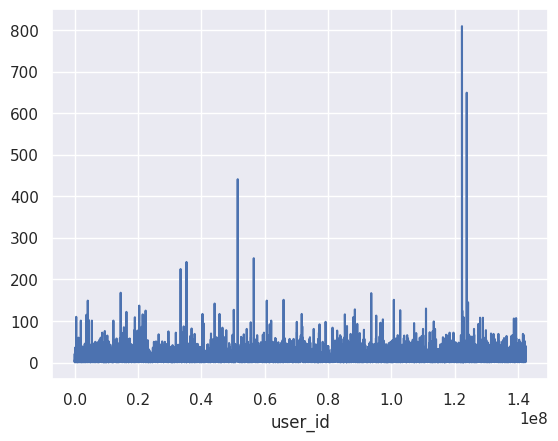

In [33]:
## 浏览 >> 加购/收藏 >> 购买（4）
data_user_buy = data_user[data_user.behavior_type==4].groupby('user_id')['behavior_type'].count()
data_user_buy.plot(x='user_id',y='buy_count')
plt.show()

X轴代表user_id，Y轴是每个用户的购买次数。可以看到，大部分用户的购买次数均不超过50次，这期间还包括了双十二当天的集中购物，排除双十二高峰，实际消费次数会更少。当然也有部分用户的购买次数超过百次，甚至有超过800次的，高频消费的用户可以看作是忠实的超级用户。

### 2. ARPU分析
ARPU(Average Revenue Per User) 表示每日的收益在所有活跃用户中的转化。详细的描述为，每日的所有收益与每日的活跃的用户数量有关，因此可以通过ARPU来计算，每日活跃用户对每日收益的转化效率。该数据集中没有对金额的体现。那我们可以对ARPU这个指标做一些修改，改为度量平台活跃用户每日平均消费次数。

计算公式为： ARPU = 每日消费总次数 / 每日活跃用户数

In [34]:
#给数据集中每一个用户赋值一个1，表示有登录操作
data_user['action'] = 1 

# 得到 date, user_id, behavior_type和计算用户每日的登录次数
data_user_arpu = data_user.groupby(['date','user_id','behavior_type'])['action'].count()
data_user_arpu = data_user_arpu.reset_index()

data_user_arpu.head(20)

,date,user_id,behavior_type,action
0,2014-11-18,4913,1,27
1,2014-11-18,4913,2,1
2,2014-11-18,7591,1,4
3,2014-11-18,12645,1,25
4,2014-11-18,54056,1,13
5,2014-11-18,54056,2,1
6,2014-11-18,54056,4,1
7,2014-11-18,79824,1,40
8,2014-11-18,79824,4,2
9,2014-11-18,88930,1,75


In [35]:
# 计算arpu，近似公式： ARPU = 每日消费次数 / 每日活跃用户数
arpu = data_user_arpu.groupby('date').apply(lambda x:x[x['behavior_type']==4]['action'].sum()/len(x['user_id'].unique()) ) 
arpu

date
2014-11-18    0.588050
2014-11-19    0.574143
2014-11-20    0.546660
2014-11-21    0.481358
2014-11-22    0.577016
2014-11-23    0.525184
2014-11-24    0.526025
2014-11-25    0.545426
2014-11-26    0.562058
2014-11-27    0.577135
2014-11-28    0.519955
2014-11-29    0.515906
2014-11-30    0.566860
2014-12-01    0.597341
2014-12-02    0.552824
2014-12-03    0.589977
2014-12-04    0.565151
2014-12-05    0.521282
2014-12-06    0.508075
2014-12-07    0.507007
2014-12-08    0.520871
2014-12-09    0.525282
2014-12-10    0.483464
2014-12-11    0.467943
2014-12-12    1.975518
2014-12-13    0.513282
2014-12-14    0.522346
2014-12-15    0.554590
2014-12-16    0.560410
2014-12-17    0.544182
2014-12-18    0.544819
dtype: float64

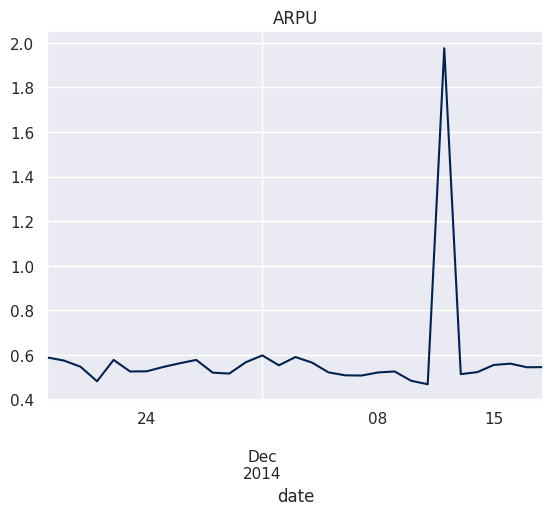

In [36]:
# 可视化
arpu.plot(colormap='cividis')
plt.title('ARPU')
plt.show()

可以看到，活跃用户每天平均消费次数在0.5次左右，双十二期间达到最高值接近2，是平时的4倍左右，表明用户会集中在大促日的时候购买。

计算ARPU过程中，分子使用的是购买累计次数，如果分子只统计购买的用户数，那么就能得到下单率，感兴趣的小伙伴可以自己去做一下分析，看看双十二当天的数据星相比平时有什么变化？

### 3. ARPPU分析
ARPPU(average revenue per paying user)是指从每位付费用户中获得的收益，它反映的是整个平台的用户消费的均值。

它的计算方式为：ARPPU = 总收入/活跃用户付费数量。但是在该数据集中没有收益金额，因此我们可以对计算方式做一点转化，将总收入转化为总的购买行为次数。

定义如下：ARPPU = 当日总消费次数/当日活跃用户付费数量， 可以看出和ARPU唯一的区别是分母，ARPU的分母是活跃用户数（包含4种行为类型），ARPPU的坟墓是活跃付费用户数，因此ARPPU的计算会更简单：

In [37]:
# 计算每日的所有用户的购买次数
data_user_arppu = data_user[data_user['behavior_type']==4].groupby(['date','user_id'])['behavior_type'].count()
data_user_arppu = data_user_arppu.reset_index().rename(columns={'behavior_type':'buy_count'})
data_user_arppu.head()

,date,user_id,buy_count
0,2014-11-18,54056,1
1,2014-11-18,79824,2
2,2014-11-18,88930,2
3,2014-11-18,247543,5
4,2014-11-18,475826,3


In [38]:
# 计算ARPPU
data_user_arppu = data_user_arppu.groupby('date').apply(lambda x:x['buy_count'].sum()/x['user_id'].count())
data_user_arppu

date
2014-11-18    2.423652
2014-11-19    2.439444
2014-11-20    2.320375
2014-11-21    2.271429
2014-11-22    2.530120
2014-11-23    2.330780
2014-11-24    2.248031
2014-11-25    2.313961
2014-11-26    2.402824
2014-11-27    2.403405
2014-11-28    2.231623
2014-11-29    2.331881
2014-11-30    2.357236
2014-12-01    2.359083
2014-12-02    2.284543
2014-12-03    2.289334
2014-12-04    2.328707
2014-12-05    2.223041
2014-12-06    2.253444
2014-12-07    2.320741
2014-12-08    2.204384
2014-12-09    2.413576
2014-12-10    2.230236
2014-12-11    2.226363
2014-12-12    3.913523
2014-12-13    2.245320
2014-12-14    2.312749
2014-12-15    2.313460
2014-12-16    2.285455
2014-12-17    2.302548
2014-12-18    2.310567
dtype: float64

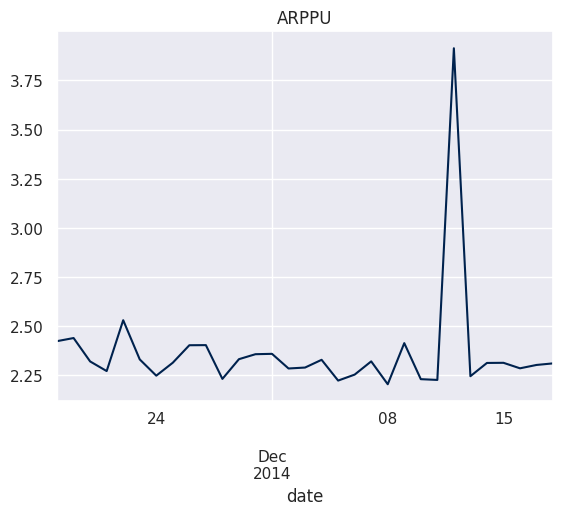

In [39]:
data_user_arppu.plot(colormap='cividis')
plt.title('ARPPU')
plt.show()

可以看到，针对活跃的下单用户来讲，平均每日消费次数在2-2.5次之间波动，双十二当天该数值达超过3.75，一个可能的原因是用户会在平时把喜欢的商品进行加购，等到双十二促销当天再下单购买。

### 4. 复购情况分析
一般来说，复购是指对产品的重复购买行为。但是这个定义在商业上是不精确的，假若一个用户在一天内多次在淘宝购买商品，不能说明这件用户对淘宝的依赖（有可能是某位用户只是第一次用，但是买的量大）。因此商业分析过程中，对于复购行为进行明确的定义。这里的复购是指：两天以上都在该平台产生了购买行为，需要指出一天多次的购买不算是复购。

因此复购率的计算方式为：复购率 = 复购用户数量 / 有购买行为的用户数量。基于这个公式，我们先计算用户在数据集中的购买频次：

In [40]:
# 计算用户购买频次
data_user_pay = data_user[data_user.behavior_type==4]
# 基于date去重，得到的结果即为购物分布的天数：
data_user_pay = data_user_pay.groupby('user_id')['date'].apply(lambda x: len(x.unique()))

# 计算复购率：
repeat_buy_ratio = data_user_pay[data_user_pay > 1].count() / data_user_pay.count()
repeat_buy_ratio

0.8717083051991897

这批抽样数据在1个月内的复购率还是相当高的，达到了0.87。

### 5. 复购周期分析
除了以上对复购频次的统计，还需要对复购意向做进一步的探究，想要知道用户多久复购一次。这个数据有助于淘宝产品宣传在这个时间间隔内采取策略，增加用户的复购意向，最终转化为实际收益。

In [41]:
data_user['action'] = 1 # 对每一行的行为记为1次，通过对行为次数的相加，从而计算频次
data_user_buy = data_user[data_user.behavior_type == 4]
data_user_buy = data_user_buy.groupby(['user_id','date'])['action'].count()
data_user_buy = data_user_buy.reset_index()
data_user_buy.head(30)

,user_id,date,action
0,4913,2014-12-01,1
1,4913,2014-12-07,2
2,4913,2014-12-11,1
3,4913,2014-12-13,1
4,4913,2014-12-16,1
5,6118,2014-12-17,1
6,7528,2014-11-22,1
7,7528,2014-11-26,1
8,7528,2014-11-27,1
9,7528,2014-11-30,1


In [42]:
# 思考： 读者可以测试下不加 dropna 是什么结果。
# data_user_buyagain = data_user_buy.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1))

# 对日期排序（按照先后顺序），给予pandas的date函数计算前后两次购物相差的天数，dropna去掉了每个用户在数据集周期内第一次购买日期的记录：
data_user_buy_date_diff = data_user_buy.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1).dropna())

data_user_buy_date_diff.head(30)

user_id    
4913     1     6 days
         2     4 days
         3     2 days
         4     3 days
7528     7     4 days
         8     1 days
         9     3 days
         10    3 days
         11   10 days
7591     13    7 days
         14    1 days
         15    1 days
         16    2 days
         17    4 days
         18    1 days
         19    1 days
         20    1 days
12645    22    2 days
         23    4 days
         24   11 days
54056    26   19 days
79824    29    9 days
         30    8 days
         31    6 days
         32    1 days
         33    1 days
         34    3 days
88930    36    2 days
         37    2 days
         38    1 days
Name: date, dtype: timedelta64[ns]

这里再稍微解释下计算的结果，第1列为索引列，即为user_id列； 第二列为该条记录在原始dataframe表中的索引位置，即data_user_buy的默认索引，第三列为同一用户相邻两个购买日期的求差结果。

以用户4913为例，在数据集周期内，共有5天有过购买行为，那么我们得到的结果是基于date列排序，并与前一天的日期做减法(diff(1))得到复购间隔天数，分别是 6(2014-12-07 - 2014-12-01)、4(2014-12-11 - 2014-12-07)、2(2014-12-13 - 2014-12-11)和 3(2014-12-16 - 2014-12-13)。第一天的记录(2014-12-01)其实也会产生一条记录为NaN，只不过被dropna给过滤掉了。

接下来我们对复购间隔进行可视化结果展示，看看有什么有价值的线索：

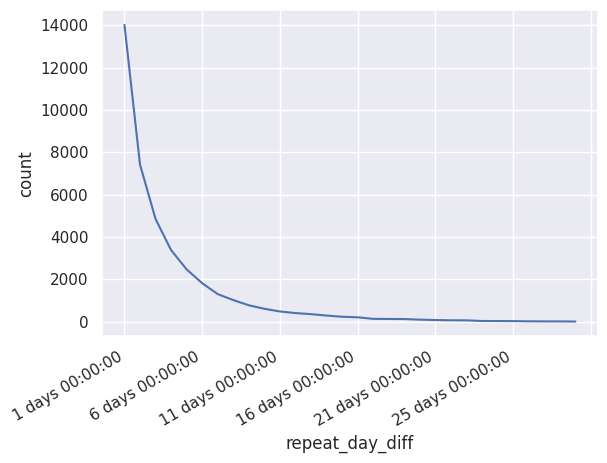

In [43]:
data_user_buy_date_diff.value_counts().plot(kind='line')

plt.xlabel('repeat_day_diff')
plt.ylabel('count')
plt.show()

上图中的横坐标有HH:MM:SS，我们只保留到days再重新绘制一下：

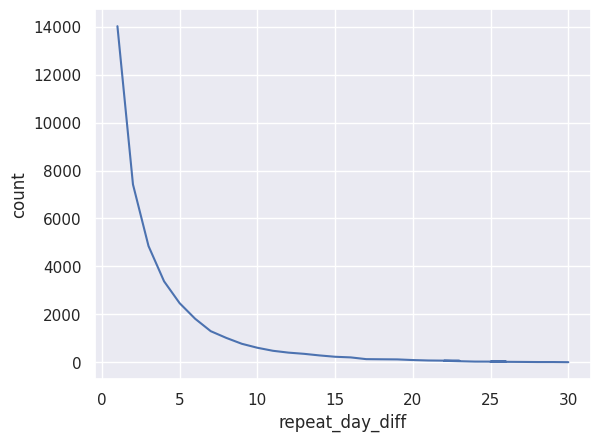

In [44]:
data_user_buy_date_diff = data_user_buy_date_diff.apply(lambda x:x.days)
data_user_buy_date_diff.value_counts().plot(kind='line')

plt.xlabel('repeat_day_diff')
plt.ylabel('count')
plt.show()

可以看出，大部分用户的复购行为发生在5天之内，在第5天复购的行为出现了明显的拐点，如果这个时候采取营销策略提升用户的购买意图，增加更多收益。超过15天后，复购的意愿基本已经趋于0，此时可以考虑采取一些召回策略，增加复购的可能性，防止用户的流失。